In [33]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt 

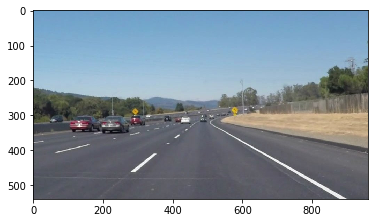

In [85]:
line = cv2.imread("imgs/line.jpg")
line_rgb = cv2.cvtColor(line,cv2.COLOR_BGR2RGB)
plt.imshow(line_rgb)
plt.show()

# Canny检测

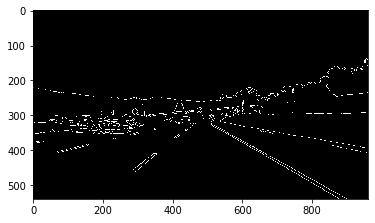

In [86]:
def do_canny(frame):
    # 将每一帧转化为灰度图像，去除多余信息
    gray = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
    # 高斯滤波器，去除噪声，平滑图像
    blur = cv.GaussianBlur(gray,(5,5),0)
    # 边缘检测
    # minVal = 50
    # maxVal = 150
    canny = cv.Canny(blur,50,150)

    return canny
canny_img = do_canny(line)
plt.imshow(canny_img,cmap="gray")

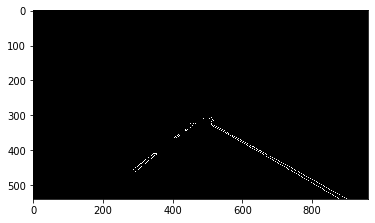

In [88]:
def do_segment(frame):
    # 获取图像高度(注意CV的坐标系,正方形左上为0点，→和↓分别为x,y正方向)
    height = frame.shape[0]

    # 创建一个三角形的区域,指定三点
    polygons = np.array([
        [(0,height), 
         (900,height),
         (500,300)]
        ])

    # 创建一个mask,形状与frame相同，全为0值
    mask = np.zeros_like(frame)

    # 对该mask进行填充，做一个掩码
    # 三角形区域为1
    # 其余为0
    cv.fillPoly(mask,polygons,255) 

    # 将frame与mask做与，抠取需要区域
    segment = cv.bitwise_and(frame,mask) 

    return segment
seg_img = do_segment(canny_img)
plt.imshow(seg_img,cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


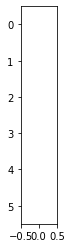

In [90]:
# 利用霍夫变换，将这些点变换到霍夫空间中，转换为直线
hough = cv2.HoughLinesP(seg_img, 2, np.pi/180, 100,minLineLength=100, maxLineGap=50) 
plt.imshow(hough,cmap="gray")

In [99]:
# 将截距与斜率转换为cv空间坐标
def calculate_coordinate(frame,parameters):
    # 获取斜率与截距
    slope, y_intercept = parameters[0],parameters[1]

    # 设置初始y坐标为自顶向下(框架底部)的高度
    # 将最终的y坐标设置为框架底部上方150
    y1 = frame.shape[0]
    y2 = int(y1-200)
    # 根据y1=kx1+b,y2=kx2+b求取x1,x2
    x1 = int((y1-y_intercept)/slope)
    x2 = int((y2-y_intercept)/slope)
    return np.array([x1,y1,x2,y2])


In [100]:
# 车道左右边界标定
def calculate_lines(frame,lines):
    # 建立两个空列表，用于存储左右车道边界坐标
    left = []
    right = []

    # 循环遍历lines
    for line in lines:
        # 将线段信息从二维转化能到一维
        x1,y1,x2,y2 = line.reshape(4)

        # 将一个线性多项式拟合到x和y坐标上，并返回一个描述斜率和y轴截距的系数向量
        parameters = np.polyfit((x1,x2), (y1,y2), 1)
        slope = parameters[0] #斜率 
        y_intercept = parameters[1] #截距

        # 通过斜率大小，可以判断是左边界还是右边界
        # 很明显左边界slope<0(注意cv坐标系不同的)
        # 右边界slope>0
        if slope < 0:
            left.append((slope,y_intercept))
        else:
            right.append((slope,y_intercept))

    # 将所有左边界和右边界做平均，得到一条直线的斜率和截距
    left_avg = np.average(left,axis=0)
    right_avg = np.average(right,axis=0)
    print(left_avg,right_avg)
    left_avg = list(left_avg)
    right_avg = list(right_avg)
    # 将这个截距和斜率值转换为x1,y1,x2,y2
    left_line = calculate_coordinate(frame,parameters=left_avg)
    right_line = calculate_coordinate(frame, parameters=right_avg)

    return np.array([left_line,right_line])

lines = calculate_lines(line, hough)

[ -0.77363879 680.36321234] [ 0.5694099  35.12303756]


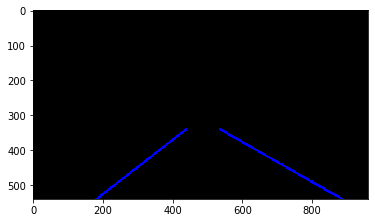

In [101]:
# 可视化车道线
def visualize_lines(frame,lines):
    lines_visualize = np.zeros_like(frame)
    # 检测lines是否为空
    if lines is not None:
        for x1,y1,x2,y2 in lines:
            # 画线
            cv.line(lines_visualize,(x1,y1),(x2,y2),(0,0,255),5)
    return lines_visualize

lines_visualize = visualize_lines(line, lines)
plt.imshow(lines_visualize,cmap="gray")

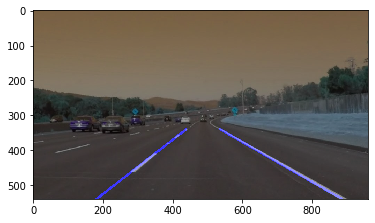

In [102]:
output = cv2.addWeighted(line,0.6,lines_visualize,1,0.1)
plt.imshow(output)